# Кластеризация и визуализация данных.

### Подгрузим необходимые библиотеки

In [80]:
import time
import pickle
import string
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.manifold import TSNE

### Получим данные

In [58]:
categories = [
        'comp.graphics',
        'sci.space',
        'rec.autos',
        'sci.electronics',
        'rec.sport.hockey',
    ]
NUM_CLUSTERS = 5
# Сохраним данные локально
# start_time = time.time()
# data_train = fetch_20newsgroups(subset='train', categories=categories,
#                                  shuffle=True, random_state=42)
# data_test = fetch_20newsgroups(subset='test', categories=categories,
#                                  shuffle=True, random_state=42)
# print(time.time() - start_time)
# with open('20news_dataset_train.pickle', 'wb') as file:
#     pickle.dump(data_train, file)
# with open('20news_dataset_test.pickle', 'wb') as file:
#     pickle.dump(data_test, file)
# print(time.time() - start_time)
def get_data(test=False):
    with open('20news_dataset_train.pickle', 'rb') as file:
            data_train = pickle.load(file)
    if not test:
        return data_train
    with open('20news_dataset_test.pickle', 'rb') as file:
        data_test = pickle.load(file)
    return data_train, data_test

## Перейдём к написанию вспомогательных функций

### Функция препроцессинга текста

In [81]:
def preprocess(line):
    line = line.lower()
    for punct in string.punctuation:
        line = line.replace(punct, '')
    return line

### Функция векторизации, поддерживаются BagOfWords и TFIDF подходы, возвращает разреженную матрицу признаков и список имён признаков

In [82]:
def vectorize_data(vec_type, data, max_features=False):
    if vec_type == 'tf':
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(data.data)
    elif vec_type == 'tfidf':
        vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', max_features=max_features if max_features else 1000,
                                     preprocessor=preprocess)
        X = vectorizer.fit_transform(data.data)
        print(vectorizer.vocabulary)
    return X, vectorizer.get_feature_names()

### Функция кластеризации, поддерживает выбор алгоритма кластеризации передачей аргументов 'kmeans', 'dbscan', 'agglomerative', 'lda', 'gmm'. Возвращает обученную модель. Число кластеров определяется с помощью GridSearch

In [50]:
def cluster_data(clustering_type, X, grid_search=False, labels=False):
    if grid_search:
        if clustering_type == 'dbscan':
            print('Invalid algorithm choice for using GridSearchCV. Try another one.')
            return
        parameters_1 = {'n_clusters': range(4, 6)}
        parameters_2 = {'n_components': range(4, 6)}
        algorithms = {'kmeans': KMeans(init='k-means++'), 'agglomerative': AgglomerativeClustering(),
                      'lda': LatentDirichletAllocation(), 'gmm': GaussianMixture()}
        algo = algorithms[clustering_type]
        if clustering_type == 'kmeans' or clustering_type == 'agglomerative':
            parameters = parameters_1
        else:
            parameters = parameters_2
        grid_search_cv_clustering = GridSearchCV(algo, parameters, cv=None)
        grid_search_cv_clustering.fit(X)
        print(grid_search_cv_clustering.best_params_)
        model = grid_search_cv_clustering.best_estimator_.fit(X)
    elif clustering_type == 'kmeans':
        model = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++').fit(X)
    elif clustering_type == 'dbscan':
        model = DBSCAN().fit(X)
    elif clustering_type == 'agglomerative':
        model = AgglomerativeClustering(n_clusters=NUM_CLUSTERS).fit(X)
    elif clustering_type == 'lda':
        model = LatentDirichletAllocation(n_components=5, max_iter=5, learning_method='online', 
                                          learning_offset=50., random_state=0).fit(X)
    elif clustering_type == 'gmm':
        model = GaussianMixture(n_components=NUM_CLUSTERS, covariance_type='full').fit(X)
    return model

### Функция для вывода "топовых" фичей для каждой категории текстов

In [7]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

### Функция для визуализации данных

In [85]:
def visualize(max_features=1000):
    start_time = time.time()
    data_train = get_data()
    X, feature_names = vectorize_data('tfidf', data_train, max_features=max_features)
    labels = data_train.target
    tsne = TSNE(n_components=2)
    X_embedded = tsne.fit_transform(X)
    palette = sns.color_palette("bright", 5)
    sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=labels, legend='full', palette=palette)
    print(f'Processed {max_features} features for {time.time() - start_time} seconds.')

### Функция для проведения эксперимента (без и с GridSearchCV)

In [79]:
def process_grid_search(max_features=1000, grid_search=False):
    start_time = time.time()
    data_train, data_test = get_data(test=True)
    labels = data_train.target
    print(f'Collected data for {time.time() - start_time} seconds.')

    start_time = time.time()
    X, feature_names = vectorize_data('tfidf', data_train, max_features=500)
    print(f'Vectorized for {time.time() - start_time} seconds.')

    start_time = time.time()
    kmeans = cluster_data('kmeans', X, grid_search=True if grid_search else False)
    print(labels)
    print(kmeans.labels_)
    print(adjusted_rand_score(labels, kmeans.labels_))
    # print(adjusted_rand_score(labels, kmeans.predict(X)))
    print(f'Clustering using KMeans has been processed for {time.time() - start_time} seconds.')

    start_time = time.time()
    dbscan = cluster_data('dbscan', X)
    print(labels)
    print(dbscan.labels_)
    print(adjusted_rand_score(labels, dbscan.labels_))
    print(f'Clustering using DBSCAN has been processed for {time.time() - start_time} seconds.')

    start_time = time.time()
    agglomerative = cluster_data('agglomerative', X.todense(), grid_search=True if grid_search else False)
    print(adjusted_rand_score(labels, agglomerative.labels_))
    print(f'Clustering using AgglomerativeClustering has been processed for {time.time() - start_time} seconds.')

    start_time = time.time()
    lda = cluster_data('lda', X, grid_search=True if grid_search else False)
    print(f'Clustering using LatentDirichletAllocation has been processed for {time.time() - start_time} seconds.')

    start_time = time.time()
    gmm = cluster_data('gmm', X.todense(), grid_search=True if grid_search else False)
    print(labels)
    print(gmm.predict(X.todense()))
    print(adjusted_rand_score(labels, gmm.predict(X.todense())))
    print(f'Clustering using Gaussian Mixture Model has been processed for {time.time() - start_time} seconds.')

    print_top_words(lda, feature_names, 20)

    print(categories)
    
    return kmeans, dbscan, agglomerative, lda, gmm

### Визуализируем исходные данные

#### Max_features=500:

None
Processed 500 features for 19.31397271156311 seconds.


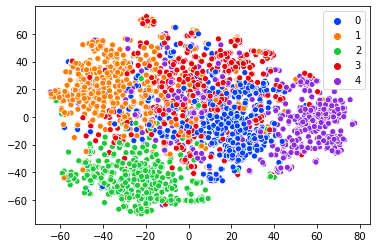

In [83]:
visualize(max_features=500)
# start_time = time.time()
# data_train = get_data()
# X, feature_names = vectorize_data('tfidf', data_train, max_features=500)
# labels = data_train.target
# tsne = TSNE(n_components=2)
# X_embedded = tsne.fit_transform(X)
# palette = sns.color_palette("bright", 5)
# sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=labels, legend='full', palette=palette)
# print(f'Processed 500 features for {time.time() - start_time} seconds.')

#### Max_features=1000:

None
Processed 500 features for 19.887128114700317 seconds.


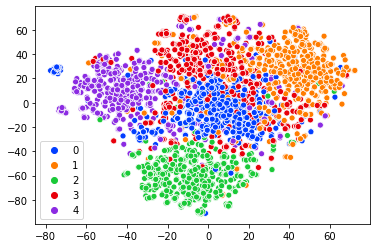

In [84]:
visualize(max_features=1000)
# start_time = time.time()
# data_train = get_data()
# X, feature_names = vectorize_data('tfidf', data_train, max_features=1000)
# labels = data_train.target
# tsne = TSNE(n_components=2)
# X_embedded = tsne.fit_transform(X)
# palette = sns.color_palette("bright", 5)
# sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=labels, legend='full', palette=palette)
# print(f'Processed 1000 features for {time.time() - start_time} seconds.')

#### Max_features=2000:

None
Processed 2000 features for 20.614306926727295 seconds.


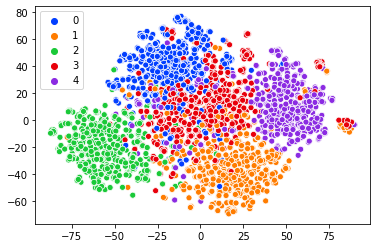

In [86]:
visualize(max_features=2000)

## Перейдём непосредственно к экспериментам

#### Во-первых, о сравнении BagOfWords и TFIDF: здесь вполне очевидны и преимущества, и недостатки обоих подходов. Более того, они взаимно вытекают друг из друга. BagOfWords быстро строится, однако больший вес отдаётся часто встречающимся в документе словам, никак не анализируется частота встречаемости слова на уровне коллекции. Таким образом, в нем большой вес могут получить просто общеупотребимые слова (даже с учетом отбрасывания стоп-слов), что однако никак не помогает нам "корректно" сравнивать полученные векторы между собой. TFIDF, напротив, строится дольше (это надстройка над подсчётом tf в BagOfWords), учитывается обратная документная частота термина, то есть редкость(для исследователя - важность) термина на уровне коллекции. Безусловно, в TFIDF больший вес получают действительно "полезные" для дальнейшего анализа фичи. Разница в скорости вычислений не настолько велика, чтобы отказаться от TFIDF. Мой выбор всегда в его пользу.

### Проведём сбор данных, векторизацию и кластеризацию без GridSearchCV описанными выше методами, смотрим время выполнения. Max_features=500.

In [75]:
kmeans, dbscan, agglomerative, lda, gmm = process_grid_search(max_features=500)

Collected data for 0.016518115997314453 seconds.
None
Vectorized for 0.5780823230743408 seconds.
[2 0 3 ... 3 1 4]
[4 2 1 ... 2 2 1]
0.2659036500184659
Clustering using KMeans has been processed for 21.231087923049927 seconds.
[2 0 3 ... 3 1 4]
[-1 -1 -1 ... -1 -1 -1]
-1.061627580446358e-05
Clustering using DBSCAN has been processed for 0.41042470932006836 seconds.
0.15028152278818097
Clustering using AgglomerativeClustering has been processed for 2.0748519897460938 seconds.
Clustering using LatentDirichletAllocation has been processed for 3.0246641635894775 seconds.
[2 0 3 ... 3 1 4]
[1 0 4 ... 4 0 2]
0.21824333785511177
Clustering using Gaussian Mixture Model has been processed for 2.4718644618988037 seconds.
Topic #0: columbia test cc change edu gary chip uk ti car reply com took ca university ibm lines high home just
Topic #1: rochester number phone ohio edu line state buffalo university thanks subject lines organization andrew cmu advance paul need cc list
Topic #2: edu com space 

### Визуализация

None
Processed 500 features for 19.0181987285614 seconds.


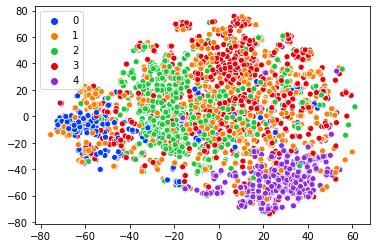

In [88]:
data_train = get_data()
labels = data_train.target
palette = sns.color_palette("bright", 5)
tsne = TSNE(n_components=2)
X, feature_names = vectorize_data('tfidf', data_train, max_features=500)

start_time = time.time()
# X = kmeans.labels_
X_embedded = tsne.fit_transform(X)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=kmeans.labels_, legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')

# palette = sns.color_palette("bright", 1)
# sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=dbscan.labels_, legend='full', palette=palette)
# print(f'Processed 500 features for {time.time() - start_time} seconds.')

# sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=gmm.predict(X.todense()), legend='full', palette=palette)
# print(f'Processed 500 features for {time.time() - start_time} seconds.')

Processed 500 features for 61.79646825790405 seconds.


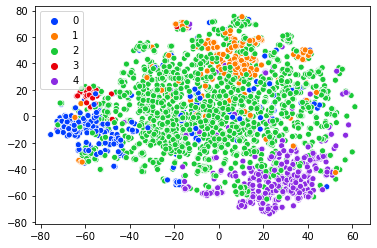

In [89]:
palette = sns.color_palette("bright", 5)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=agglomerative.labels_, legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')

### Проведём сбор данных, векторизацию и кластеризацию без GridSearchCV описанными выше методами, смотрим время выполнения. Max_features=1000.

In [90]:
kmeans, dbscan, agglomerative, lda, gmm = process_grid_search(max_features=1000)

Collected data for 0.01701641082763672 seconds.
None
Vectorized for 0.6569879055023193 seconds.
[2 0 3 ... 3 1 4]
[4 1 2 ... 2 2 0]
0.3571704741065289
Clustering using KMeans has been processed for 28.321611404418945 seconds.
[2 0 3 ... 3 1 4]
[-1 -1 -1 ... -1 -1 -1]
-1.2438492866269665e-05
Clustering using DBSCAN has been processed for 0.41539621353149414 seconds.
0.20376263963624994
Clustering using AgglomerativeClustering has been processed for 2.1037979125976562 seconds.
Clustering using LatentDirichletAllocation has been processed for 3.5274288654327393 seconds.
[2 0 3 ... 3 1 4]
[0 3 3 ... 3 1 4]
0.33039827933993965
Clustering using Gaussian Mixture Model has been processed for 3.00797438621521 seconds.
Topic #0: car writes article dont just lines like subject organization university nntppostinghost im know cars good think use time power new
Topic #1: team game hockey games nhl play players season university win writes cup teams pittsburgh think subject organization leafs lines p

### Визуализация

None
Processed 500 features for 18.789491653442383 seconds.


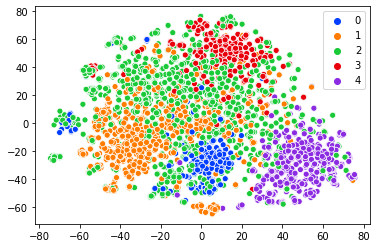

In [91]:
data_train = get_data()
labels = data_train.target
palette = sns.color_palette("bright", 5)
tsne = TSNE(n_components=2)
X, feature_names = vectorize_data('tfidf', data_train, max_features=1000)

start_time = time.time()
# X = kmeans.labels_
X_embedded = tsne.fit_transform(X)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=kmeans.labels_, legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')


# palette = sns.color_palette("bright", 1)
# sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=dbscan.labels_, legend='full', palette=palette)
# print(f'Processed 500 features for {time.time() - start_time} seconds.')



# sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=gmm.predict(X.todense()), legend='full', palette=palette)
# print(f'Processed 500 features for {time.time() - start_time} seconds.')

Processed 500 features for 23.053906440734863 seconds.


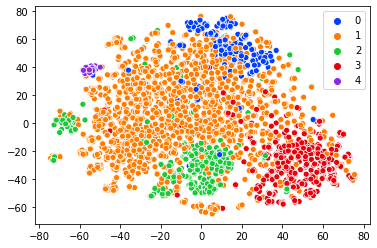

In [92]:
palette = sns.color_palette("bright", 5)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=agglomerative.labels_, legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')

### Проведём сбор данных, векторизацию и кластеризацию без GridSearchCV описанными выше методами, смотрим время выполнения. Max_features=2000.

In [93]:
kmeans, dbscan, agglomerative, lda, gmm = process_grid_search(max_features=2000)

Collected data for 0.015542984008789062 seconds.
None
Vectorized for 0.6458520889282227 seconds.
[2 0 3 ... 3 1 4]
[2 4 0 ... 0 0 1]
0.3502033758621664
Clustering using KMeans has been processed for 25.49655294418335 seconds.
[2 0 3 ... 3 1 4]
[-1 -1 -1 ... -1 -1 -1]
-1.2438492866269665e-05
Clustering using DBSCAN has been processed for 0.44542837142944336 seconds.
0.20376263963624994
Clustering using AgglomerativeClustering has been processed for 2.0490005016326904 seconds.
Clustering using LatentDirichletAllocation has been processed for 3.157895565032959 seconds.
[2 0 3 ... 3 1 4]
[1 0 3 ... 3 3 4]
0.33832500646830155
Clustering using Gaussian Mixture Model has been processed for 2.068978786468506 seconds.
Topic #0: car writes article dont just lines like subject organization university nntppostinghost im know cars good think use time power new
Topic #1: team game hockey games nhl play players season university win writes cup teams pittsburgh think subject organization leafs lines p

### Визуализация

None
Processed 500 features for 18.788464069366455 seconds.


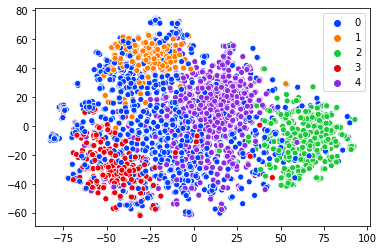

In [94]:
data_train = get_data()
labels = data_train.target
palette = sns.color_palette("bright", 5)
tsne = TSNE(n_components=2)
X, feature_names = vectorize_data('tfidf', data_train, max_features=2000)

start_time = time.time()
# X = kmeans.labels_
X_embedded = tsne.fit_transform(X)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=kmeans.labels_, legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')


# palette = sns.color_palette("bright", 1)
# sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=dbscan.labels_, legend='full', palette=palette)
# print(f'Processed 500 features for {time.time() - start_time} seconds.')

# sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=gmm.predict(X.todense()), legend='full', palette=palette)
# print(f'Processed 500 features for {time.time() - start_time} seconds.')

Processed 500 features for 31.332409620285034 seconds.


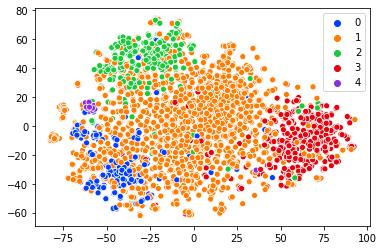

In [95]:
palette = sns.color_palette("bright", 5)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=agglomerative.labels_, legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')

### Проведём сбор данных, векторизацию и кластеризацию с поиском числа кластеров с помощью GridSearchCV описанными выше методами, смотрим время выполнения. Тут же проводим оценку качества. Max_features=500:

In [ ]:
kmeans, dbscan, agglomerative, lda, gmm = process_grid_search(max_features=500, grid_search=True)

Collected data for 0.017171859741210938 seconds.
None
Vectorized for 0.6343834400177002 seconds.


### Визуализация

In [ ]:
data_train = get_data()
labels = data_train.target
palette = sns.color_palette("bright", 5)
tsne = TSNE(n_components=2)
X, feature_names = vectorize_data('tfidf', data_train, max_features=2000)

start_time = time.time()
# X = kmeans.labels_
X_embedded = tsne.fit_transform(X)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=kmeans.labels_, legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')


palette = sns.color_palette("bright", 1)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=dbscan.labels_, legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')

palette = sns.color_palette("bright", 5)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=agglomerative.labels_, legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=gmm.predict(X.todense()), legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')

### Проведём сбор данных, векторизацию и кластеризацию с поиском числа кластеров с помощью GridSearchCV описанными выше методами, смотрим время выполнения. Тут же проводим оценку качества. Max_features=1000:

In [ ]:
kmeans, dbscan, agglomerative, lda, gmm = process_grid_search(max_features=1000, grid_search=True)

### Визуализация

In [ ]:
data_train = get_data()
labels = data_train.target
palette = sns.color_palette("bright", 5)
tsne = TSNE(n_components=2)
X, feature_names = vectorize_data('tfidf', data_train, max_features=2000)

start_time = time.time()
# X = kmeans.labels_
X_embedded = tsne.fit_transform(X)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=kmeans.labels_, legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')


palette = sns.color_palette("bright", 1)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=dbscan.labels_, legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')

palette = sns.color_palette("bright", 5)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=agglomerative.labels_, legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=gmm.predict(X.todense()), legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')

### Проведём сбор данных, векторизацию и кластеризацию с поиском числа кластеров с помощью GridSearchCV описанными выше методами, смотрим время выполнения. Тут же проводим оценку качества. Max_features=2000:

In [ ]:
kmeans, dbscan, agglomerative, lda, gmm = process_grid_search(max_features=1000, grid_search=True)

### Визуализация

In [ ]:
data_train = get_data()
labels = data_train.target
palette = sns.color_palette("bright", 5)
tsne = TSNE(n_components=2)
X, feature_names = vectorize_data('tfidf', data_train, max_features=2000)

start_time = time.time()
# X = kmeans.labels_
X_embedded = tsne.fit_transform(X)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=kmeans.labels_, legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')


palette = sns.color_palette("bright", 1)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=dbscan.labels_, legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')

palette = sns.color_palette("bright", 5)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=agglomerative.labels_, legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=gmm.predict(X.todense()), legend='full', palette=palette)
print(f'Processed 500 features for {time.time() - start_time} seconds.')

## Выводы: